<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/003_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.9 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import gc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Read Data

## Datasets

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]

        inputs = tokenizer.encode_plus(
                text1, 
                add_special_tokens=True,
                padding='max_length',
                max_length = self.max_length,
                return_tensors='pt',
                truncation=True,
                return_attention_mask=True
                )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids_lyrics': ids.flatten(),
            'attention_mask_lyrics': mask.flatten(),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDatasetMulitpleText(Dataset):
    def __init__(self, data_all,tokenizer,max_length, item2pos, user2id):
        super(LFM2bDatasetMulitpleText, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index]['lyrics_cleaned']
        text2 = self.data_all.iloc[index]['tags']
        text3 = self.data_all.iloc[index]['abstract']
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs1 = tokenizer.encode_plus(
            text1, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        inputs2 = tokenizer.encode_plus(
            text2, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        inputs3 = tokenizer.encode_plus(
            text3, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids3 = inputs1["input_ids"]
        mask3 = inputs1["attention_mask"]

        return {
            'input_ids_lyrics': torch.tensor(ids1, dtype=torch.long),
            'attention_mask_lyrics': torch.tensor(mask1, dtype=torch.long),
            'input_ids_tags': torch.tensor(ids2, dtype=torch.long),
            'attention_mask_tags': torch.tensor(mask2, dtype=torch.long),
            'input_ids_abstract': torch.tensor(ids3, dtype=torch.long),
            'attention_mask_abstract': torch.tensor(mask3, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


## Read Data: Lyrics 

In [8]:
dir = "preprocessed_data/"

data_interaction = pd.read_csv(dir + "data_interaction.csv").drop(['Unnamed: 0'],axis=1)
data_tracks_tags_lyrics = pd.read_csv(dir + "data_tracks_tags_lyrics.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_test = pd.read_csv(dir + "data_interaction_test.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_train = pd.read_csv(dir + "data_interaction_train.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_val = pd.read_csv(dir + "data_interaction_val.csv").drop(['Unnamed: 0'],axis=1)

In [9]:
pos2item = {i:v for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}
item2pos = {v:i for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}

id2user = {i:v for i, v in enumerate(data_interaction.user_id.sort_values().unique())}
user2id = {v:i for i, v in enumerate(data_interaction.user_id.sort_values().unique())}

# Ask Me Anything Rating

Code source: https://github.com/nlp-deepcbrs/amar

In [10]:
def get_ndcg(df, rel_pred, k):

  rel_true = np.zeros(len(df))
  rel_true[:k] = 1

  def _dcg(rel):
    i = np.arange(1, len(rel)+ 1)
    denom = np.log2(i + 1)
    dcg = np.sum(rel / denom)
    return dcg

  return _dcg(rel_pred) / _dcg(rel_true)



## **BERT Model**

In [11]:
class AMARBase(nn.Module):
  """Model with LT tables for user and items."""
  def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, num_users, num_items):
      super(AMARBase, self).__init__()

      self.hidden_dense_layer_size = hidden_dense_layer_size
      self.item_embeddings_size = item_embeddings_size
      self.user_embeddings_size = user_embeddings_size
      self.num_items = num_items
      self.num_users = num_users

      self.model1_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)
      nn.init.uniform_(self.model1_layer1.weight, a=-0.05, b=0.05)

      self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)
      nn.init.uniform_(self.model2_layer1.weight, a=-0.05, b=0.05)

      self.linear1 = nn.Linear(self.hidden_dense_layer_size, 128)

      self.relu = nn.ReLU()
      
      self.linear2 = nn.Linear(128, 1)

      self.drop =  nn.Dropout(p=0.2)
      self.sigmoid = nn.Sigmoid()
      
  def forward(self, x):
      y1 = self.model1_layer1(x[0])
      
      y2 = self.model2_layer1(x[2])

      y = torch.cat((y1, y2), 1) 
      y = self.linear1(y)
      y = self.relu(y)
      y = self.linear2(y)
      return self.sigmoid(y)


In [12]:
from transformers import AutoConfig, AutoModel, AutoTokenizer
MODEL_NAME = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels = 2)

hidden_dense_layer_size=778

MODEL_NAME = 'prajjwal1/bert-tiny'
#MODEL_NAME = 'bert-base-uncased'

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
class AMARBertEmbeddings(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items, hidden_layer=32):
        super(AMARBert, self).__init__()

        self.hidden_dense_layer_size = hidden_dense_layer_size
        self.item_embeddings_size = item_embeddings_size
        self.user_embeddings_size = user_embeddings_size
        self.item_text_embeddings_size = item_text_embeddings_size
        self.num_items = num_items
        self.num_users = num_users
        
        self.model1_layer2 = BertModel.from_pretrained(MODEL_NAME)
        self.model1_layer3 = nn.Dropout(p=0.3)

        self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size)
        nn.init.uniform_(self.model2_layer1.weight, a=0.0, b=0.05)

        self.model3_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size)
        nn.init.uniform_(self.model3_layer1.weight, a=0.0, b=0.05)
        
        self.linear1 = nn.Linear(self.hidden_dense_layer_size, self.hidden_dense_layer_size)
        nn.init.xavier_uniform(self.linear1.weight)
        self.linear1.bias.data.fill_(0.01)

        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dense_layer_size, hidden_layer)
        nn.init.xavier_uniform(self.linear2.weight)
        self.linear2.bias.data.fill_(0.01)

        self.linear3 = nn.Linear(hidden_layer, 1)
        nn.init.xavier_uniform(self.linear3.weight)
        self.linear3.bias.data.fill_(0.01)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output = self.model1_layer2(x[1], attention_mask = x[3])
        y1 = output[0]
        #y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
        y1 = y1[:,0,:]
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        y1 = self.model1_layer3(y1)
        
        y2 = self.model2_layer1(x[2])

        y3 = self.model3_layer1(x[0])

        y = torch.cat([y1, y2, y3], 1)
        y = self.linear1(y)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.linear3(y)
        return self.sigmoid(y)


In [14]:
class AMARBertMultiple(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items, hidden_layer=32):
        super(AMARBertMultiple, self).__init__()

        self.hidden_dense_layer_size = hidden_dense_layer_size
        self.item_embeddings_size = item_embeddings_size
        self.user_embeddings_size = user_embeddings_size
        self.item_text_embeddings_size = item_text_embeddings_size
        self.num_items = num_items
        self.num_users = num_users
        
        self.model1_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model1_layer3 = nn.Dropout(p=0.2)

        self.model4_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model4_layer3 = nn.Dropout(p=0.2)

        self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)
        nn.init.uniform_(self.model2_layer1.weight, a=0.0, b=0.05)

        self.model3_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)
        nn.init.uniform_(self.model3_layer1.weight, a=0.0, b=0.05)
        
        self.linear1 = nn.Linear(self.hidden_dense_layer_size, self.hidden_dense_layer_size)
        nn.init.xavier_uniform(self.linear1.weight)
        self.linear1.bias.data.fill_(0.01)

        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dense_layer_size, hidden_layer)
        nn.init.xavier_uniform(self.linear2.weight)
        self.linear2.bias.data.fill_(0.01)

        self.linear3 = nn.Linear(hidden_layer, 1)
        nn.init.xavier_uniform(self.linear3.weight)
        self.linear3.bias.data.fill_(0.01)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output = self.model1_layer2(x[1], attention_mask = x[3])
        y1 = output[0]
        #y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
        y1 = y1[:,0,:]
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        y1 = self.model1_layer3(y1)

        output = self.model1_layer2(x[4], attention_mask = x[5])
        y4 = output[0]
        #y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
        y4 = y4[:,0,:]
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        y4 = self.model4_layer3(y4)
        
        y2 = self.model2_layer1(x[2])

        y3 = self.model3_layer1(x[0])

        y = torch.cat([y1, y2, y3, y4], 1)
        
        y = self.linear1(y)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.linear3(y)
        
        return self.sigmoid(y)


In [15]:
class AMARBert(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users, hidden_layer=32):
        super(AMARBert, self).__init__()
        self.model1_layer2 = BertModel.from_pretrained(MODEL_NAME)
        self.model1_layer3 = nn.Dropout(p=0.3)

        self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)
        
        self.linear = nn.Linear(hidden_dense_layer_size, hidden_dense_layer_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dense_layer_size, hidden_layer)
        self.linear3 = nn.Linear(hidden_layer, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output = self.model1_layer2(x[1], attention_mask = x[3])
        y1 = output[0]
        #y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
        y1 = y1[:, 0, :]
        # pooled_output (=y1) is the output of the CLS token
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        # https://stackoverflow.com/questions/63673511/how-to-use-the-outputs-of-bert-model?rq=1
        # https://towardsdatascience.com/bert-to-the-rescue-17671379687f
        y1 = self.model1_layer3(y1)
        
        y2 = self.model2_layer1(x[2])

        y = torch.cat([y1, y2], 1)
        y = self.linear(y)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.linear3(y)
        return self.sigmoid(y)

In [16]:
device = 'cuda'

import numpy as np
item_text_embeddings_size = 128
user_embeddings_size = 100
item_embeddings_size = 10#128
text_col = 'tags'#abstract'


tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) 
dataset_train= LFM2bDataset(data_interaction_train,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
dataset_val= LFM2bDataset(data_interaction_val,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)

# dataset_train= LFM2bDatasetMulitpleText(data_interaction_train,tokenizer,item_text_embeddings_size,  item2pos, user2id)
# dataset_val= LFM2bDatasetMulitpleText(data_interaction_val,tokenizer,item_text_embeddings_size,  item2pos, user2id)

num_users = len(data_interaction['user_id'].drop_duplicates())
num_items = len(pos2item)

hidden_dense_layer_size_base = item_embeddings_size + user_embeddings_size
model_base = AMARBase(hidden_dense_layer_size_base, item_embeddings_size, user_embeddings_size, num_users, num_items)

# hidden_dense_layer_size_bert = item_embeddings_size + 2 * item_text_embeddings_size + user_embeddings_size
# model_bert = AMARBertMultiple( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)

# hidden_dense_layer_size_bert = item_embeddings_size + item_text_embeddings_size + user_embeddings_size
# model_bert = AMARBertEmbeddings( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)

# hidden_dense_layer_size_bert = user_embeddings_size  +item_text_embeddings_size 
# model = AMARBert(hidden_dense_layer_size_bert, user_embeddings_size, num_users)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [17]:
#model_dir = f"./results/input_{text_col}_userEmb_optim_rms_model_{MODEL_NAME}/"
model_dir = f"./results/input_userEmb_itemEmb_optim_rms_model_{MODEL_NAME}/"
import os
os.makedirs(model_dir, exist_ok=True)

In [37]:
from transformers import get_linear_schedule_with_warmup
gc.collect()
torch.cuda.empty_cache()

model = model_base.to(device)

num_epochs=15
batch_size=32

dataloader_train=DataLoader(dataset=dataset_train,batch_size=batch_size, num_workers=4)
dataloader_val=DataLoader(dataset=dataset_val,batch_size=batch_size, num_workers=4)

criterion = nn.BCELoss()
lr = 1e-3
num_total_steps = len(dataset_train) * num_epochs
num_warmup_steps = 0
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
optimizer =  torch.optim.RMSprop(model.parameters(), lr= lr, alpha=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)#, correct_bias=False)  


scheduler = get_linear_schedule_with_warmup(
   optimizer,
   num_warmup_steps=num_warmup_steps,
   num_training_steps=num_total_steps
)


loss_train = []
loss_val = []
ndcg_val = []

best_ndcg = 0
cnt = 0

for e in range(num_epochs):

    losses_train = []

    model.train()

    for data_train in dataloader_train:
        gc.collect()
        torch.cuda.empty_cache()
        model.zero_grad()
        #items positions
        curr_items_ids_batch = data_train['track_id']
        # items descriptions
        curr_items_batch = data_train['input_ids_lyrics']
        curr_attentions_batch = data_train['attention_mask_lyrics']

        # additional items descriptions
        # curr_items_batch1 = data_train['input_ids_tags']
        # curr_attentions_batch1 = data_train['attention_mask_tags']
        
        # users ids
        curr_users_batch =data_train['user_id']

        # model inputs
        inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), curr_items_batch.type(torch.LongTensor).to(device), 
                  curr_users_batch.type(torch.LongTensor).to(device), curr_attentions_batch.type(torch.LongTensor).to(device),
                  # curr_items_batch1.type(torch.LongTensor).to(device),  curr_attentions_batch1.type(torch.LongTensor).to(device)
                  ]

        # model targets
        targets = data_train['target'].reshape(-1,1)

        # backward propagation
        outputs = model(inputs)

        loss = criterion(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # evaluate current loss function value
        losses_train.append(loss.item())

    # compute loss on validation set
    model.eval()

    losses_val = []

    res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
    for data_val in dataloader_val:
      gc.collect()
      torch.cuda.empty_cache()
      #items positions
      curr_items_ids_batch = data_val['track_id']
      # items descriptions
      curr_items_batch = data_val['input_ids_lyrics']
      curr_attentions_batch = data_val['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data_val['input_ids_tags']
      # curr_attentions_batch1 = data_val['attention_mask_tags']
      
      # users ids
      curr_users_batch =data_val['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device), 
                # curr_attentions_batch1.type(torch.LongTensor).to(device)
                ]

      # model targets
      targets = data_val['target'].reshape(-1,1)

      with torch.no_grad():        
        outputs_val = model(inputs)

      loss = criterion(outputs_val, targets.to(device))
      losses_val.append(loss.item())

      for i in range(outputs_val.shape[0]):
        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs_val[i].item()} , index=[0]))

    # compute ndcg for each user
    ndcg = []
    for user, df in res.groupby('user_id'):
      df = df.drop_duplicates(subset='track_id').sort_values('count', ascending=False)
      y_true_sorted = data_interaction_val.loc[data_interaction_val['user_id'] == user].sort_values('count', ascending=False).drop_duplicates()
      rel_pred = pd.merge(df[['track_id']], y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)['count'].values
      ndcg.append(get_ndcg(df, rel_pred, 10))

    ndcg_e = np.mean(ndcg)
    
    # save best model based on ndcg
    if ndcg_e > best_ndcg:
      best_ndcg = ndcg_e
      print(f"\nSaving best model for epoch: {e}\n")
      torch.save(model.state_dict(), model_dir + 'best_model.pth')
      cnt = 0
    else:
      cnt = cnt+1
    if cnt > 4:
      break

    average_los_val = np.mean(losses_val)
    loss_val.append(average_los_val.item())    
    ndcg_val.append(ndcg_e)
   
    # evaluate average cost per epoch
    average_loss_train = np.mean(losses_train)
    loss_train.append(average_loss_train.item())
    print(f"Epoch {e} | Average loss per epoch: Train: {average_loss_train.item()} , Val: {average_los_val.item()}, NDCG: {ndcg_e}")



Saving best model for epoch: 0

Epoch 0 | Average loss per epoch: Train: 0.6927334921637054 , Val: 0.7023824104546431, NDCG: 0.504370217605634
Epoch 1 | Average loss per epoch: Train: 0.6419755906333791 , Val: 0.8037256389544506, NDCG: 0.5038623364239031
Epoch 2 | Average loss per epoch: Train: 0.5930991626313801 , Val: 0.8751196418909749, NDCG: 0.504369342337744

Saving best model for epoch: 3

Epoch 3 | Average loss per epoch: Train: 0.5579924838004287 , Val: 0.9204063048678128, NDCG: 0.5051995866518002

Saving best model for epoch: 4

Epoch 4 | Average loss per epoch: Train: 0.5307381858455509 , Val: 0.9563441704875151, NDCG: 0.5061562352758449

Saving best model for epoch: 5

Epoch 5 | Average loss per epoch: Train: 0.5063716633072478 , Val: 0.9824987841694879, NDCG: 0.5077191864383929

Saving best model for epoch: 6

Epoch 6 | Average loss per epoch: Train: 0.484433525624961 , Val: 1.0026352021548068, NDCG: 0.5085363541218565

Saving best model for epoch: 7

Epoch 7 | Average los

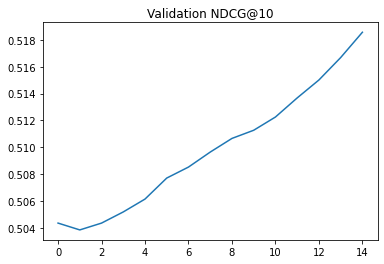

In [38]:
plt.plot(ndcg_val)
plt.title("Validation NDCG@10")

#from google.colab import files
plt.savefig(model_dir + "ndcg.png")
#files.download(model_dir + "ndcg.png") 

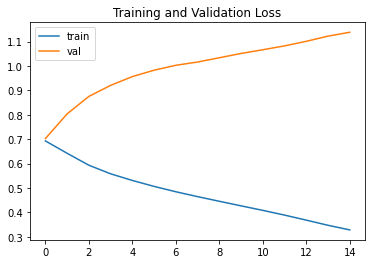

In [39]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend()
plt.title("Training and Validation Loss")

#from google.colab import files
plt.savefig(model_dir + "loss.png")
#files.download(model_dir + "loss.png") 

## **BERT**: Get predictions

In [ ]:
batch_size= 32
res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
dataset_test= LFM2bDataset(data_interaction_test,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
# dataset_test= LFM2bDatasetMulitpleText(data_interaction_test,tokenizer,item_text_embeddings_size,  item2pos, user2id)
dataloader_test=DataLoader(dataset=dataset_test,batch_size=batch_size, num_workers=4)

#model = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)
hidden_dense_layer_size_base = item_embeddings_size + user_embeddings_size
model = AMARBase(hidden_dense_layer_size_base, item_embeddings_size, user_embeddings_size, num_users, num_items)
model.load_state_dict(torch.load(model_dir + 'best_model.pth'))
model.to(device)
model.eval()


for data in dataloader_test:
      gc.collect()
      torch.cuda.empty_cache()
      #items positions
      curr_items_ids_batch = data['track_id']
      # items descriptions
      curr_items_batch = data['input_ids_lyrics']
      curr_attentions_batch = data['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data['input_ids_tags']
      # curr_attentions_batch1 = data['attention_mask_tags']
      
      # users ids
      curr_users_batch =data['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device), 
                # curr_attentions_batch1.type(torch.LongTensor).to(device),
                ]


      with torch.no_grad():
        outputs = model(inputs)


      # save prediction for each user
      for i in range(outputs.shape[0]):

        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs[i].item()} , index=[0]))
        

In [ ]:
res[(res.user_id == 1120)].sort_values('count', ascending = False)#.head(10)

In [ ]:
res[res.user_id == 546].sort_values('count', ascending = False)#.head(10) 

In [ ]:
topn=100
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user, user_prediction in res.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

In [ ]:
results_df.to_csv(model_dir + 'predictions.csv', encoding = 'utf-8-sig') 

# Most popular recommendation


In [12]:
data_interaction_test[data_interaction_test.user_id == 24988]['count'].sum()

7

In [13]:
topn = 100

item_popularity_df = data_interaction_test.groupby('track_id')['count'].sum().sort_values(ascending=False).reset_index()

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train['user_id'] == real_user_id]['track_id'].values
    item_popularity_df_user = item_popularity_df[~item_popularity_df['track_id'].isin(items_to_ignore)]
    predictions[real_user_id].append(item_popularity_df_user.head(topn)['track_id'].values.tolist())

In [14]:
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={'user_id':[user],'track_id':[item],'count':[rating]})))
        results.append([user, item, rating])

In [12]:
results_df

,user_id,track_id,count
0,27960,1968,1.0
0,27960,5837012,1.0
0,27960,5833218,1.0
0,27960,5834213,1.0
0,27960,5834217,1.0
...,...,...,...
0,38810,5616212,1.0
0,38810,5628442,1.0
0,38810,5819912,1.0
0,38810,5628783,1.0


# Random recommendation

In [18]:
topn = 100
import random

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train['user_id'] == real_user_id]['track_id'].values
    item_df_user = data_interaction_test[~data_interaction_test['track_id'].isin(items_to_ignore)]
    predictions[real_user_id].append(random.sample(set(item_df_user['track_id'].values), topn))

In [19]:
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={'user_id':[user],'track_id':[item],'count':[rating]})))
        results.append([user, item, rating])

# Evaluate predictions

Scores: F1@10, ndcg@k, recall@k

In [ ]:
topn=100

In [ ]:
#results_df = pd.read_csv(model_dir + "predictions.csv").drop(["Unnamed: 0"], axis=1)

In [ ]:
f1_scores = []
recall_scores = []
ndcg_scores = []

for user, df in results_df.groupby('user_id'):
  df = df.drop_duplicates(subset='track_id')

  y_true_sorted = data_interaction_test.loc[data_interaction_test['user_id'] == user].sort_values('count', ascending=False).drop_duplicates()
  rel = pd.merge(df[['track_id']], y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)['count'].values
  y_true_df = pd.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)
  y_true_ndcg = y_true_df['count'].values
  y_true_df.loc[y_true_df['count'] > 0, 'count'] = 1
  y_true = y_true_df['count'].values

  y_pred_df = pd.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), df[['track_id', 'count']], 'left').fillna(0)
  y_pred_ndcg = y_pred_df['count'].values
  y_pred_df.loc[y_pred_df['count'] > 0, 'count'] = 1
  y_pred = y_pred_df['count'].values

  if y_true.sum() >= 1:
    f1_scores.append(f1_score(y_true, y_pred))
    recall_scores.append(recall_score(y_true, y_pred))
    ndcg_scores.append(get_ndcg(df, rel, topn))

print("F1 Score: ", np.mean(f1_scores))
print("Recall Score: ", np.mean(recall_scores))
print("NDCG Score: ", np.mean(ndcg_scores))

In [ ]:
pd.DataFrame({"f1_score": [np.mean(f1_scores)], 'recall': [np.mean(recall_scores)], 'ndcg': [np.mean(ndcg_scores)]}).to_csv(model_dir + 'evaluation_result.csv', encoding = 'utf-8-sig') 